**Import/Setup** 

In [ ]:
import cv2
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from google.colab.patches import cv2_imshow
from PIL import Image

In [ ]:
MODELPATH = './models/model.h5'
DATAPATH='fer2013.csv'

**Data Preprocessing**


In [ ]:
my_data= pd.read_csv(DATAPATH) #0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
my_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 25, 48

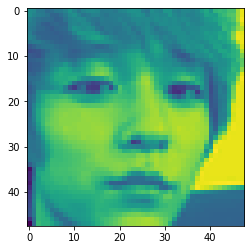

In [ ]:
imagebuffer = np.array(my_data['pixels'])
images = np.array([np.fromstring(image,np.uint8,sep=' ') for image in imagebuffer])
num_shape = int(np.sqrt(images.shape[-1]))
images.shape = (images.shape[13],num_shape,num_shape)
plt.imshow(images[13])

In [ ]:
import face_recognition
def show_landmarks(img):
  face_landmarks = face_recognition.face_landmarks(img)
  xs = []
  ys = []
  for landmark in face_landmarks:
      for k, v in landmark.items():
        xs += [x[0] for x in v]
        ys += [x[1] for x in v]
  fig, ax = plt.subplots()
  fig.set_size_inches(5, 5)
  ax.imshow(img)
  ax.scatter(x=xs, y=ys, c='red', s=10)

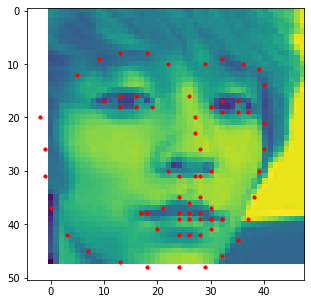

In [ ]:
show_landmarks(images[13])

In [ ]:
import math 
def getCropIndex(pointA, pointB):
  return ( (pointA[0]+pointB[0])/2 ,(pointA[1]+pointB[1])/2 )
from scipy import interpolate

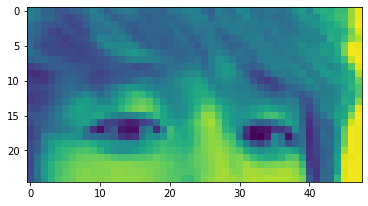

In [ ]:
img=images[13]
img_crop = img.copy()
img_crop.resize((25,48))
plt.imshow(img_crop) 

In [ ]:
def calculateNoseLandmark():
  landmark_images=[]
  i=0
  for img in images:
    lm= face_recognition.face_landmarks(img)
    if(len(lm)>0):
      nb= lm[0]['nose_bridge']
      crop_index = getCropIndex(nb[0], nb[3])
      if( (crop_index[1]<=25) and (crop_index[1]>=21) ):
        landmark_images.append([img, crop_index, i])
    i+=1
  return landmark_images

In [ ]:
def cropImages(landmark_images):
  images_cropped=[]
  for face in landmark_images:
    cface = face[0].copy()
    cface.resize((25,48))
    images_cropped.append(cface)
  return images_cropped

In [ ]:
landmark_images = calculateNoseLandmark()
cropped_images = cropImages(landmark_images)
print(len(images))
print(len(landmark_images)) #number of images which have decipherable facial landmarks and fall within threshold

35887
17769


In [ ]:
def load_cropped_randomtest():
  faces = []
  indices = [my_data['emotion'][li[2]] for li in landmark_images]
  emotions = pd.get_dummies(indices)#one hot encoding 
  for face in cropped_images:
    face = face / 255.0
    face = cv2.resize(face.astype('float32'), (25, 48))
    faces.append(face.astype('float32'))
  faces = np.asarray(faces)
  faces = np.expand_dims(faces, -1) 
  data, test_data, labels, test_labels = train_test_split(faces, emotions, test_size=0.1, random_state=42)
  return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

In [ ]:
def load_data_randomtest(dataset_path):
  faces = []
  pixels = my_data['pixels'].tolist()
  emotions = pd.get_dummies(my_data['emotion'])#one hot encoding 
  for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] 
    face = np.asarray(face).reshape(width, height) 
    face = face / 255.0
    face = cv2.resize(face.astype('float32'), (width, height))
    faces.append(face.astype('float32'))
  faces = np.asarray(faces)
  faces = np.expand_dims(faces, -1) 
  data, test_data, labels, test_labels = train_test_split(faces, emotions, test_size=0.1, random_state=42)
  return data, labels, test_data, test_labels

In [ ]:
def load_data_privatetest(dataset_path):
  data = [] 
  test_data = []
  test_labels = []
  labels =[]
  with open(dataset_path, 'r') as file:      
    for line_no, line in enumerate(file.readlines()):          
      if 0 < line_no <= 35887: 
        curr_class, line, set_type = line.split(',')
        image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)            
        image_data =image_data.astype(np.uint8)/255.0                        
        if (set_type.strip() == 'PrivateTest'):                            
          test_data.append(image_data)              
          test_labels.append(curr_class)           
        else:              
          data.append(image_data)              
          labels.append(curr_class)            
  test_data = np.expand_dims(test_data, -1)      
  test_labels = pd.get_dummies(test_labels)      
  data = np.expand_dims(data, -1)         
  labels = pd.get_dummies(labels)          
  return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

In [ ]:
X_train, y_train, X_test, y_test =  load_cropped_randomtest()

**Building the Model**

In [ ]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(48, 25, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 46, 23, 64)        640       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 46, 23, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 46, 23, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 11, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 23, 11, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 23, 11, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 11, 128)      

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)

**Training**

In [ ]:
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

Train on 15992 samples, validate on 1777 samples
Epoch 1/100
15992/15992 [==============================] - 6s 357us/step - loss: 0.6219 - accuracy: 0.7816 - val_loss: 1.4265 - val_accuracy: 0.5656

Epoch 00001: val_loss improved from inf to 1.42645, saving model to ./models/model_cropped.h5
Epoch 2/100
15992/15992 [==============================] - 6s 349us/step - loss: 0.6108 - accuracy: 0.7919 - val_loss: 1.5279 - val_accuracy: 0.5492

Epoch 00002: val_loss did not improve from 1.42645
Epoch 3/100
15992/15992 [==============================] - 6s 350us/step - loss: 0.6118 - accuracy: 0.7894 - val_loss: 1.5196 - val_accuracy: 0.5504

Epoch 00003: val_loss did not improve from 1.42645
Epoch 4/100
15992/15992 [==============================] - 6s 347us/step - loss: 0.6119 - accuracy: 0.7895 - val_loss: 1.4030 - val_accuracy: 0.5599

Epoch 00004: val_loss improved from 1.42645 to 1.40304, saving model to ./models/model_cropped.h5
Epoch 5/100
15992/15992 [==============================] 

In [ ]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=batch_size)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

1777/1777 [==============================] - 0s 114us/step
Loss: 1.5142168141377395
Accuracy: 0.5734384059906006


In [ ]:
model.save_weights("model_weights.h5")

**Predicting with Pre-trained Model**

In [ ]:
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

In [ ]:
truey=[]
predy=[]
x = np.load('./X_test.npy')
y = np.load('./y_test.npy')

y_prime= loaded_model.predict(x)
yp = y_prime.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    predy.append(yp[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

np.save('truey', truey)
np.save('predy', predy)
print("Predictions saved")
print("Accuracy on test set :"+str(acc)+"%")